<a href="https://colab.research.google.com/github/christakahashi/ECE447/blob/master/lectures/test-signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ECE 447: Test Signals
===

Updated by 
 Dr. Chris Takahashi

Authored by Prof. Eric Klavins &copy; 2019, University of Washington


# Code

In [0]:
import numpy as np
import scipy.integrate as spi
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from sympy import *

%matplotlib inline

#comment out for light mode
plt.style.use('dark_background')

try: 
  import google.colab #test for colab
  import IPython
  def setup_typeset():
    """MathJax initialization for the current cell.
    
    This installs and configures MathJax for the current output.
    """
    IPython.display.display(IPython.display.HTML('''
        <script src="https://www.gstatic.com/external_hosted/mathjax/latest/MathJax.js?config=TeX-AMS_HTML-full,Safe&delayStartupUntil=configured"></script>
        <script>
          (() => {
            const mathjax = window.MathJax;
            mathjax.Hub.Config({
            'tex2jax': {
              'inlineMath': [['$', '$'], ['\\(', '\\)']],
              'displayMath': [['$$', '$$'], ['\\[', '\\]']],
              'processEscapes': true,
              'processEnvironments': true,
              'skipTags': ['script', 'noscript', 'style', 'textarea', 'code'],
              'displayAlign': 'center',
            },
            'HTML-CSS': {
              'styles': {'.MathJax_Display': {'margin': 0}},
              'linebreaks': {'automatic': true},
              // Disable to prevent OTF font loading, which aren't part of our
              // distribution.
              'imageFont': null,
            },
            'messageStyle': 'none'
          });
          mathjax.Hub.Configured();
        })();
        </script>
        '''))
  def custom_latex_printer(exp,**options):
      setup_typeset()
      return printing.latex(exp,**options)
  init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)
except:
  init_printing(use_latex='mathjax')

# Test Signals

Inputs of various types are used to test whether a system responds as desired. You can model what the user might or will do with these signals. The signals common used are:

| Name      | Time Domain   | Frequency Domain |
| :-------- | :------------ | :--------------- |
| Impulse   | $\delta(t)$   | 1                |
| Step      | 1             | $1/s$            |
| Ramp      | $t$           | $1/s^2$          |
| Parabola  | $t^2$         | $2/s^3$          |
| Sine Wave | $\sin(\omega t)$ | $\omega / ( s^2 + \omega^2)$ |

As a reminder $\mathcal{L}(t^n) = n! / s^{n+1}$.

Our goal is to show that a control system's ability to track an input test signal at steady state depends on the number of poles at the origin, also known as the **system type**.

Formally, suppose we have a system in a feedback configuration as follows:

<img width=50% src="https://raw.githubusercontent.com/klavins/ECE447/master/images/test-signal-diagram.png">

In this case, you can think of $G(s)$ as the controller composed in series with the plant. The general form for $G(s)$ is

$$
G(s) = \frac{\Pi_{k=1}^Q(s+z_k)}
            {s^N\;\Pi_{k=1}^M(s+p_k)}
$$

where

- $z_1 \dots z_Q$ are the zeros
- $p_1 \dots p_M$ are the non-zero poles
 
and there are $N$ poles at zero. 

We define

- The **system type** to be $N$
- The **system order** to be $N+M$

Now recall that the error for the above system is

$$
E(s) = R(s) - Y(s) = R(s) - E(s)G(s)
$$

so that

$$
E(s) = \frac{1}{1+G(s)}R(s).
$$

In this notebook, we are interested in the steady state error, 

$$
e(\infty) =\lim_{s \rightarrow 0} \frac{sR(s)}{1+G(s)}.
$$

Impulse Response: $R(s) = 1$
---

In this case 

$$
\lim_{s \rightarrow 0} \frac{s}{1+G(s)} = 0.
$$

> Therefore: Any stable system can track an impulse perfectly at steady state. That's because at steady state, the output of a system with zero input is zero.

Step Response: $R(s) = 1/s$
---

If $N=0$, then

$$
e(\infty) =\lim_{s \rightarrow 0} \frac{s\cdot\frac{1}{s}}{1+G(s)} = \frac{1}{1+G(0)}.
$$

Sometimes $G(0)$ is denoted $K_P$. If $N>0$ then 

$$
\lim_{s \rightarrow 0}G(s) = \infty,
$$

so

$$
e(\infty) = \frac{1}{\infty} = 0.
$$

> Therefore, when there are no poles at zero in $G(s)$, there is a non-zero steady state error. Otherwise, the steady state error is zero (as we saw with PI control, which intentionally adds a pole at zero).

Ramp Response: $R(s) = 1/s^2$
---

Here, 

\begin{align}
e(\infty) & = \lim_{s \rightarrow 0} \frac{s\cdot\frac{1}{s^2}}{1+G(s)} \\ 
 & = \lim_{s \rightarrow 0} \frac{1}{s+sG(s)} \\
 & = \lim_{s \rightarrow 0} \frac{1}{sG(s)}.
\end{align}

If $N=0$, then there is no pole to cancel the $s$ multiplying $G(s)$ in the denominator. Thus, 

$$
e(\infty) = \infty
$$

If $N=1$, then 

$$
e(\infty) = \frac{1}{K_V}
$$

where $K_V \triangleq \lim_{s \rightarrow 0} sG(s)$.

If $N \geq 2$, then we get 

$$
e(\infty) = \lim_{s \rightarrow 0} \frac{s}{G(s)} = 0.
$$

> Therefore, A system with two poles at zero can perfectly track a ramp. With one pole, it has a non-zero steady state error for a ramp input, and with no poles, it can't track a ramp at all.

Parabola Response: $R(s) = 2/s^3$
---

Here, 

\begin{align}
e(\infty) & = \lim_{s \rightarrow 0} \frac{s\cdot\frac{2}{s^3}}{1+G(s)} \\ 
 & = \lim_{s \rightarrow 0} \frac{1}{s^2+s^2G(s)} \\
 & = \lim_{s \rightarrow 0} \frac{1}{s^2G(s)}.
\end{align}

Using logic similar to the above:

If $N \leq 1$, then $e(\infty) = \infty$.

If $N = 2$, then $e(\infty) = \frac{1}{K_A}$ where $K_A \triangleq \lim_{s \rightarrow 0} s^2G(s)$.

If $N \geq 3$ then $e(\infty) = 0$.

General Picture
---

So the type of the system determines the kind of signals a system can track.

|N     |1     |$1/s$   |$1/s^2$  |$2/s^3$  |
| :--- | :--- | :----- | :------ | :------ |
| 0    | 0    | $\frac{1}{1+K_p}$ | $\infty$ | $\infty$ |
| 1    | 0    | 0      | $\frac{1}{K_V}$ | $\infty$ |
| 2    | 0    | 0      | 0 | $\frac{1}{K_A}$ |
| 3    | 0    | 0      | 0 | 0 | 
| $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |

In [2]:
# Example
var("a", real=True)
var("t", real=True,positive=True)
var("s")

# Controller with one poles
G = 1/(s+2)
Gc = 1/s
T = G*Gc / ( 1 + Gc*G )

# Step response
R1 = 1/s
Y1 = T*R1
Y1 = Y1.cancel()

# Ramp Reponse
R2 = 1/(s**2)
Y2 = T*R2
Y2 = Y2.cancel()

limit(s*(R1-Y1),s,0), limit(s*(R2-Y2),s,0)

(0, 2)

In [3]:
Y1, Y2

⎛      1              1       ⎞
⎜─────────────, ──────────────⎟
⎜ 3      2       4      3    2⎟
⎝s  + 2⋅s  + s  s  + 2⋅s  + s ⎠

/usr/local/lib/python3.6/dist-packages/sympy/plotting/plot.py:890: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  self.ax.spines['left'].set_smart_bounds(True)
/usr/local/lib/python3.6/dist-packages/sympy/plotting/plot.py:891: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  self.ax.spines['bottom'].set_smart_bounds(False)


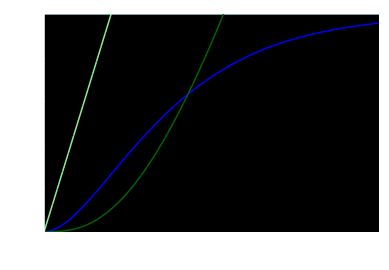

In [4]:
# Find solutions in time domain for each y
y1 = inverse_laplace_transform(Y1, s, t)
y2 = inverse_laplace_transform(Y2, s, t)
y1,y2

# Plot showing the system tracking a step, but not a ramp
plots = plotting.plot(y1,1+0*t,y2,t,(t,0,5), show=false);
plots[0].line_color = 'blue'
plots[1].line_color = 'lightblue'
plots[2].line_color = 'darkgreen'
plots[3].line_color = 'lightgreen'
plots.show()

# Control Design


The general picture is:

<img width=40% src="https://raw.githubusercontent.com/klavins/ECE447/master/images/test-signal-control.png">

**Scenarios**: Say $G(s)$ does not have any poles at zero.

1) You want to track a step, but are okay with steady state error. Then choose $G_c(s) = K_p$. By tuning $K$, you can make SSE as small as you want. Larger $K$ also makes the system snappier.

2) You want to track a step with no SSE, then choose $G_c(s) = K_I / s$. This will give you the tracking you want, although it may not have very good transient response.

3) You want to track a step with no SSE and a snappy response, then choose $G_c(s) = K_p + K_I / s$. By tuning both gains, you can usually achieve the response you need.